In [1]:
## Preparation

# Import the necessary libraries
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
import optuna
import time

from activation import Swish, ResidualBlock

## Global Var

dataset_path = os.getcwd() + '/dataset/classified'

class_labels = ["Normal", "Cataract"]

In [2]:
print(f"Is using CUDA? {torch.cuda.is_available()}")  # Should return True if CUDA is available
print(torch.version.cuda)  # Check the CUDA version PyTorch is using
print(torch.cuda.current_device()) # Check CUDA device used

Is using CUDA? True
12.6
0


In [3]:
# Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load Dataset
ds = datasets.ImageFolder(root=dataset_path, transform=transform)

indices = list(range(len(ds)))
# labels = [ds.targets[i] for i in indices]

# Split into train and test dataset
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_ds = Subset(ds, train_indices)
test_ds = Subset(ds, test_indices)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False, pin_memory=True, num_workers=4)

total_samples  = len(train_ds) + len(test_ds)

print(f"Train size: {(len(train_ds) / total_samples) * 100:.2f}%, Test size: {(len(test_ds)/total_samples)*100:.2f}%")
print(f"Total samples: {total_samples}, Train size: {len(train_ds)}, Test size: {len(test_ds)}")

Train size: 79.98%, Test size: 20.02%
Total samples: 1159, Train size: 927, Test size: 232


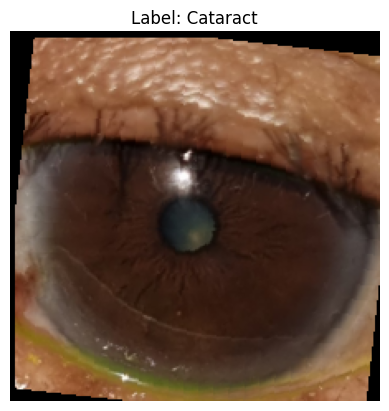

In [4]:
def denormalize(tensor, mean=None, std=None):
    if std is None:
        std = [0.5, 0.5, 0.5]
    if mean is None:
        mean = [0.5, 0.5, 0.5]
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean  # Reverse normalization

# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Select one image
img = images[0]
label = labels[0].item()

# Denormalize image
img = denormalize(img)

# Convert from Tensor (C, H, W) to NumPy (H, W, C)
img = np.transpose(img.numpy(), (1, 2, 0))

# Plot the image
plt.imshow(img)
plt.title(f"Label: {class_labels[label]}")  # Display label
plt.axis("off")
plt.show()

In [5]:
# Optuna Hyperparameter

best_trial = None
best_model = None

torch.backends.cudnn.benchmark = True

device_name = "cuda" if torch.cuda.is_available() else "cpu"
use_amp = device_name == "cuda"


def objective(trial: optuna.Trial) -> float:
    device = torch.device(device_name)

    # Define hyperparameters
    lr = trial.suggest_float("lr", 1e-3, 1e-1, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.3, 0.5)
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "SGD"])
    num_epochs = trial.suggest_int("num_epochs", 5, 10)  # Fixed at 5 epochs

    model = models.efficientnet_b0(progress=True, weights=models.EfficientNet_B0_Weights.DEFAULT)

    for param in model.features[:-2].parameters():
        param.requires_grad = False

    number_of_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Linear(number_of_features, 256),
        nn.BatchNorm1d(256),
        Swish(),

        ResidualBlock(256, 256),
        nn.Dropout(dropout_rate),

        ResidualBlock(256, 128),
        nn.Dropout(dropout_rate),

        nn.Linear(128, 1)
    ).to(device)

    model.to(device)

    # Define loss and optimizer
    criterion = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    if optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    train_losses = []
    train_accuracies = []

    scaler = torch.amp.GradScaler(device=device_name)

    # Training Loop
    for epoch in range(num_epochs):

        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)

            optimizer.zero_grad()

            with torch.amp.autocast("cuda", enabled=use_amp):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        scheduler.step()

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = correct / total * 100

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

        trial.set_user_attr("train_losses", train_losses)
        trial.set_user_attr("train_accuracies", train_accuracies)

        # Pruning: Stop bad trials early
        trial.report(epoch_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Evaluate Model
    model.eval()
    correct, total = 0, 0
    trial_preds = []
    trial_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            trial_preds.extend(preds.cpu().numpy())
            trial_labels.extend(labels.cpu().numpy())

    test_acc = correct / total * 100
    print(f"🎯 Test Accuracy: {test_acc:.2f}%")

    # **Save best model globally**
    global best_model, best_trial

    try:
        best_trial = trial.study.best_trial
        best_value = trial.study.best_value
    except ValueError:
        best_value = float('-inf')

    if best_model is None or (best_trial is not None and test_acc > best_value):
        best_model = model.state_dict()

    best_acc = trial.study.user_attrs.get("best_accuracy", 0)

    if test_acc > best_acc:
        study.set_user_attr("best_accuracy", test_acc)

        trial_preds = np.array(trial_preds).flatten().tolist()
        trial_labels = np.array(trial_labels).flatten().tolist()

        study.set_user_attr("best_preds", trial_preds)
        study.set_user_attr("best_labels", trial_labels)

    return test_acc

In [6]:
study = optuna.create_study(
    direction="maximize",
    study_name=f"hyperparam cataract classifier_{int(time.time())}",
    pruner=optuna.pruners.MedianPruner(),
    storage="sqlite:///optuna.db",
    load_if_exists=True
)

study.optimize(
    objective,
    n_trials=20,
    n_jobs=4,
    show_progress_bar=True
)

acc = study.best_value

print("\nBest Hyperparameters:", study.best_params)
print("\nAccuracy:", acc)

[I 2025-03-13 04:55:04,701] A new study created in RDB with name: hyperparam cataract classifier_1741816504


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/10], Loss: nan, Accuracy: 71.31%
Epoch [1/6], Loss: nan, Accuracy: 75.51%
Epoch [1/6], Loss: 0.6180, Accuracy: 63.97%
Epoch [1/5], Loss: 0.4897, Accuracy: 75.40%
Epoch [2/6], Loss: 0.3982, Accuracy: 81.98%
Epoch [2/5], Loss: 0.2578, Accuracy: 89.97%
Epoch [2/6], Loss: nan, Accuracy: 90.61%
Epoch [2/10], Loss: nan, Accuracy: 90.83%
Epoch [3/5], Loss: 0.1928, Accuracy: 91.69%
Epoch [3/6], Loss: nan, Accuracy: 92.77%
Epoch [3/10], Loss: nan, Accuracy: 92.45%
Epoch [3/6], Loss: 0.2918, Accuracy: 87.81%
Epoch [4/5], Loss: 0.1602, Accuracy: 93.10%
Epoch [4/6], Loss: nan, Accuracy: 93.64%
Epoch [4/10], Loss: nan, Accuracy: 94.39%
Epoch [4/6], Loss: 0.2387, Accuracy: 90.94%
Epoch [5/5], Loss: 0.1173, Accuracy: 94.71%
Epoch [5/6], Loss: nan, Accuracy: 95.04%
Epoch [5/10], Loss: nan, Accuracy: 94.61%
Epoch [5/6], Loss: 0.1937, Accuracy: 92.45%
Epoch [6/6], Loss: nan, Accuracy: 95.36%
Epoch [6/10], Loss: nan, Accuracy: 95.15%
Epoch [6/6], Loss: 0.2063, Accuracy: 93.31%
🎯 Test Accuracy: 9

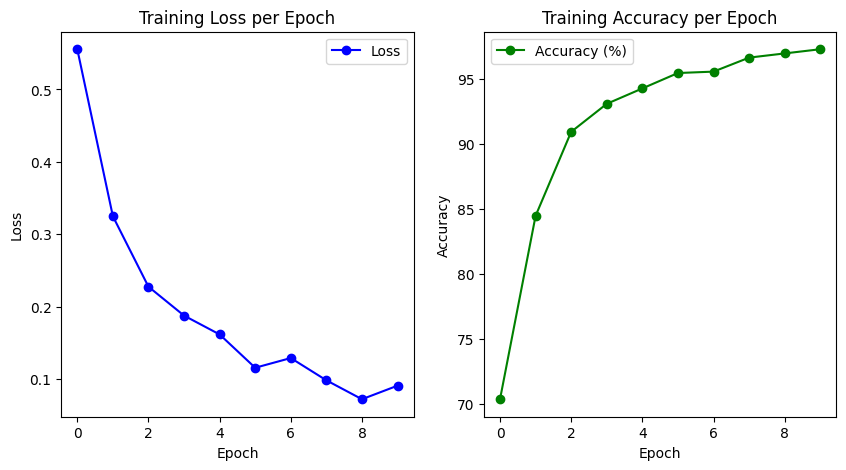

In [7]:
best_trial = study.best_trial
best_train_losses = best_trial.user_attrs.get("train_losses", [])
best_train_accuracies = best_trial.user_attrs.get("train_accuracies", [])

plt.figure(figsize=(10, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(best_train_losses, label="Loss", marker="o", linestyle="-", color="b")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(best_train_accuracies, label="Accuracy (%)", marker="o", linestyle="-", color="g")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy per Epoch")
plt.legend()

plt.show()

Accuracy: 94.83%
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       170
         1.0       0.93      0.87      0.90        62

    accuracy                           0.95       232
   macro avg       0.94      0.92      0.93       232
weighted avg       0.95      0.95      0.95       232



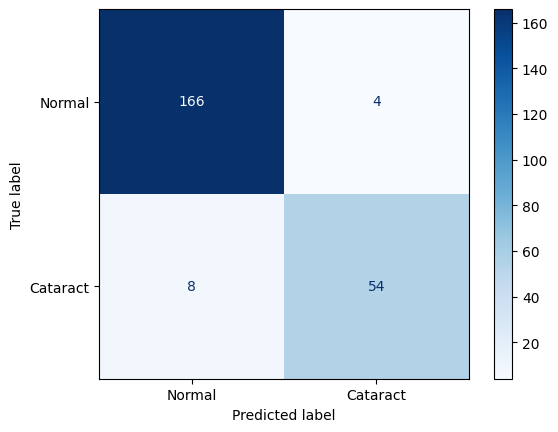

In [8]:
best_preds = np.array(study.user_attrs.get("best_preds", []))
best_labels = np.array(study.user_attrs.get("best_labels", []))

conf_matrix = confusion_matrix(best_preds, best_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap=plt.cm.Blues)
cr = classification_report(best_preds, best_labels)

print(f"Accuracy: {acc:.2f}%")
print(cr)

In [9]:
# # save
output_model_path = f"output/checkpoint-{acc}-hyperparam.pth"

torch.save({
    "model_state_dict": study.user_attrs.get("best_model_state"),  # Best model weights
    "optimizer_state_dict": study.user_attrs.get("best_optimizer_state"),  # Best optimizer state
    "best_hyperparameters": study.best_params,
    "best_accuracy": study.best_value,
    "best_train_losses": study.user_attrs.get("best_train_losses", []),  # Best training loss per epoch
    "best_train_accuracies": study.user_attrs.get("best_train_accuracies", []),  # Best accuracy per epoch
}, output_model_path)

In [10]:
# checkpoint = torch.load("checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# model.eval()